In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import ndimage

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
np.random.seed(42)
torch.manual_seed(42)

CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

In [3]:
with h5py.File(CUBE_PATH, "r") as cube:
    spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()

In [4]:
metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

with h5py.File(CUBE_PATH, "r") as cube:
    spectra_zoom0 = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:][mask]
    images_zoom0 = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:][mask]

metadata_indices_filtered = metadata_indices[mask]
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]

In [5]:
def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]
labels_simplified = pd.Series(labels).apply(simplify_targettype).values
valid_target_mask = np.isin(labels_simplified, ["GALAXY", "QUASAR", "STAR"])
valid_indices = ~np.isnan(spectra_zoom0).any(axis=1)
final_mask = valid_target_mask & valid_indices
print("Number of objects after filtering:", final_mask.sum())

Number of objects after filtering: 11139


In [6]:
Y_all = valid_sfrs.loc[metadata_indices_filtered, "AVG"].values
Y = Y_all[final_mask]

filters = ["u", "g", "r", "i", "z"]

In [7]:
all_images = []
all_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask]
        spectra_zoom = cube[spec_key][:][mask]
    
    images_zoom = images_zoom[final_mask]
    spectra_zoom = spectra_zoom[final_mask]
    
    if zoom == 0:
        reference_spectrum = spectra_zoom.copy()
        reference_images = images_zoom.copy()
    
    min_val_spec = np.min(reference_spectrum, axis=1, keepdims=True)
    max_val_spec = np.max(reference_spectrum, axis=1, keepdims=True)
    spectra_zoom_normalized = 2 * (spectra_zoom - min_val_spec) / (max_val_spec - min_val_spec) - 1
    
    min_val_img = np.min(reference_images, axis=(2, 3), keepdims=True)
    max_val_img = np.max(reference_images, axis=(2, 3), keepdims=True)
    images_zoom_normalized = 2 * (images_zoom - min_val_img) / (max_val_img - min_val_img) - 1
    
    all_images.append(images_zoom_normalized)
    all_spectra.append(spectra_zoom_normalized)

CROP_SIZES_4 = {
    0: 32,  #  64
    1: 16,  #  32
    2: 8,   #  16
    3: 4    #  8
}


In [8]:
cropped_images = []
for zoom in range(4):
    img_array = all_images[zoom]
    original_size = img_array.shape[-1]
    target_size = CROP_SIZES_4.get(zoom, original_size)
    start = (original_size - target_size) // 2
    end = start + target_size
    cropped = img_array[..., start:end, start:end]
    cropped_images.append(cropped)

In [9]:
def detect_and_visualize_multiple_objects(all_images, thresholds, max_objects=20, thumbnail_size=3, crop_sizes=None):
    all_images_trimmed = []
    for i, img_array in enumerate(all_images):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        all_images_trimmed.append(trimmed)
    
    multi_obj_indices = []
    for idx in range(all_images_trimmed[0].shape[0]):
        image = all_images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds[0]
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    
    if multi_obj_indices:
        display_indices = multi_obj_indices if len(multi_obj_indices) <= max_objects else multi_obj_indices[:max_objects]
        num_rows = len(display_indices)
        fig, axes = plt.subplots(num_rows, 5, figsize=(15, thumbnail_size * num_rows), dpi=100)
        if num_rows == 1:
            axes = axes.reshape(1, -1)
        for row, obj_idx in enumerate(display_indices):
            for col in range(5):
                ax = axes[row, col]
                img_data = all_images_trimmed[0][obj_idx, col, :, :]
                ax.imshow(img_data, vmin=-1, vmax=1)
                ax.set_title(f"Filter {filters[col]}")
                ax.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print("No multi-object sources found")
    
    return all_images_trimmed, multi_obj_indices

THRESHOLDS_4 = {
    0: 0.90,
    1: 0.93,
    2: 0.97,
    3: 0.99
}

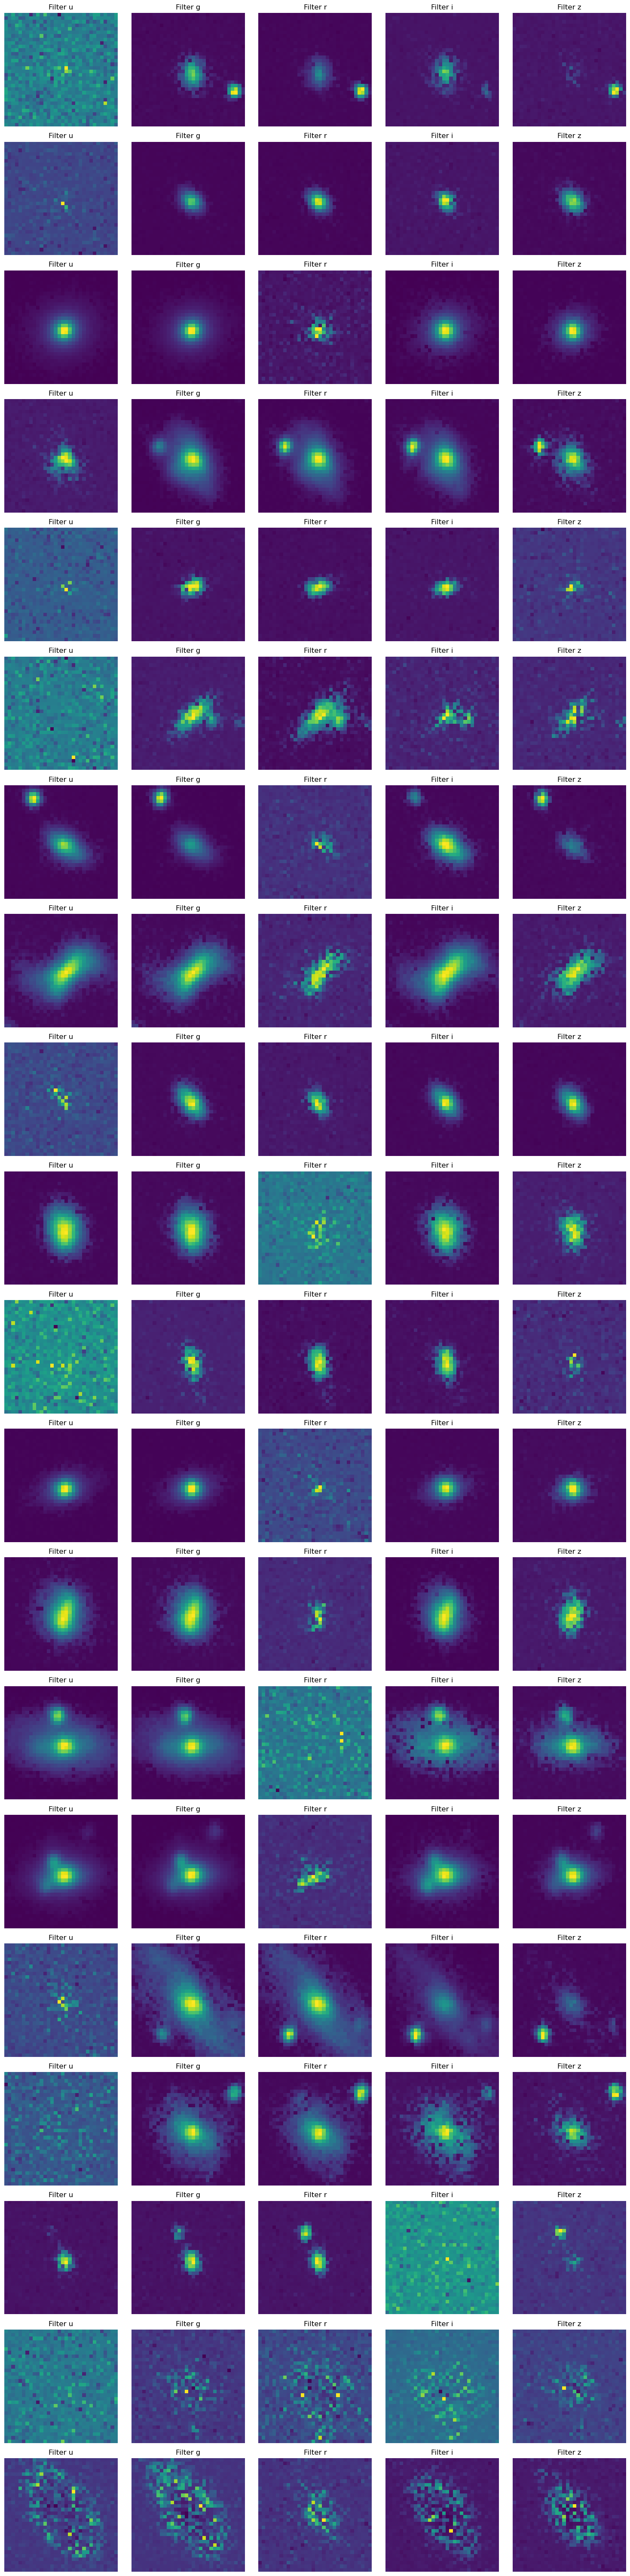

In [10]:
cropped_images, multi_obj_indices = detect_and_visualize_multiple_objects(
    cropped_images, thresholds=THRESHOLDS_4, crop_sizes=CROP_SIZES_4
)

In [11]:
if multi_obj_indices:
    valid_idx = np.ones(cropped_images[0].shape[0], dtype=bool)
    valid_idx[multi_obj_indices] = False
    cropped_images = [img_arr[valid_idx] for img_arr in cropped_images]
    all_spectra = [spec_arr[valid_idx] for spec_arr in all_spectra]
    Y = Y[valid_idx]
    print(f"Removed {len(multi_obj_indices)} images with multiple objects.")

Removed 757 images with multiple objects.


In [12]:
X_img = cropped_images[0]
n_samples = X_img.shape[0]
X_img = X_img.reshape(n_samples, -1)

In [13]:
X_img_train, X_img_temp, X_spec_train, X_spec_temp, y_train, y_temp = train_test_split(
    X_img, all_spectra[0], Y, test_size=0.4, random_state=42, shuffle=True)

X_img_val, X_img_test, X_spec_val, X_spec_test, y_val, y_test = train_test_split(
    X_img_temp, X_spec_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

In [14]:
# Early Fusion Model
class EarlyFusionNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Intermediate Fusion Model
class IntermediateFusionNet(nn.Module):
    def __init__(self, img_dim, spec_dim):
        super().__init__()
        self.img_branch = nn.Sequential(
            nn.Linear(img_dim, 64), nn.ReLU(), nn.Dropout(0.3)
        )
        self.spec_branch = nn.Sequential(
            nn.Linear(spec_dim, 32), nn.ReLU(), nn.Dropout(0.3)
        )
        self.fusion = nn.Sequential(
            nn.Linear(96, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, img, spec):
        img_feat = self.img_branch(img)
        spec_feat = self.spec_branch(spec)
        combined = torch.cat([img_feat, spec_feat], dim=1)
        return self.fusion(combined)

# Late Fusion Model
class LateFusionNet(nn.Module):
    def __init__(self, img_dim, spec_dim):
        super().__init__()
        self.img_net = nn.Sequential(
            nn.Linear(img_dim, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
        self.spec_net = nn.Sequential(
            nn.Linear(spec_dim, 32), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, img, spec):
        img_pred = self.img_net(img)
        spec_pred = self.spec_net(spec)
        return (img_pred + spec_pred) / 2

In [15]:
img_pca_components = 100
spec_pca_components = {0: 50, 1: 40, 2: 30, 3: 20} 
batch_size = 64
epochs = 100
patience = 10
learning_rate = 0.0005

results_fusion = {}
train_loss_history = {}
val_loss_history = {}

fusion_methods = {
    "Early Fusion": EarlyFusionNet,
    "Intermediate Fusion": IntermediateFusionNet,
    "Late Fusion": LateFusionNet
}



Processing zoom level 0

Training Early Fusion for zoom level 0
Epoch 1: Train Loss = 0.7390, Val Loss = 0.4934
Epoch 2: Train Loss = 0.5414, Val Loss = 0.4735
Epoch 3: Train Loss = 0.4988, Val Loss = 0.4599
Epoch 4: Train Loss = 0.4721, Val Loss = 0.4443
Epoch 5: Train Loss = 0.4481, Val Loss = 0.4381
Epoch 6: Train Loss = 0.4380, Val Loss = 0.4289
Epoch 7: Train Loss = 0.4237, Val Loss = 0.4253
Epoch 8: Train Loss = 0.4158, Val Loss = 0.4157
Epoch 9: Train Loss = 0.4097, Val Loss = 0.4217
Epoch 10: Train Loss = 0.3980, Val Loss = 0.4116
Epoch 11: Train Loss = 0.4013, Val Loss = 0.4118
Epoch 12: Train Loss = 0.3930, Val Loss = 0.4064
Epoch 13: Train Loss = 0.3855, Val Loss = 0.4081
Epoch 14: Train Loss = 0.3874, Val Loss = 0.4023
Epoch 15: Train Loss = 0.3749, Val Loss = 0.3999
Epoch 16: Train Loss = 0.3682, Val Loss = 0.3976
Epoch 17: Train Loss = 0.3671, Val Loss = 0.3966
Epoch 18: Train Loss = 0.3599, Val Loss = 0.3961
Epoch 19: Train Loss = 0.3589, Val Loss = 0.3925
Epoch 20: Tra

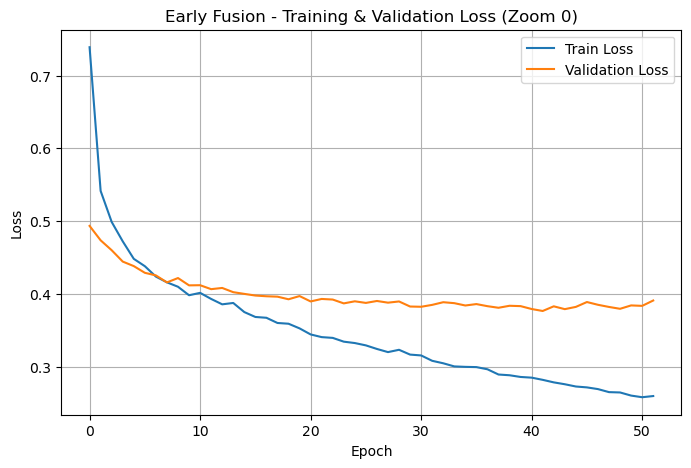

Early Fusion - Zoom 0 - RMSE: 0.6247, R2: 0.2476

Training Intermediate Fusion for zoom level 0
Epoch 1: Train Loss = 0.9548, Val Loss = 0.5091
Epoch 2: Train Loss = 0.5804, Val Loss = 0.4926
Epoch 3: Train Loss = 0.5161, Val Loss = 0.4749
Epoch 4: Train Loss = 0.4981, Val Loss = 0.4614
Epoch 5: Train Loss = 0.4745, Val Loss = 0.4485
Epoch 6: Train Loss = 0.4604, Val Loss = 0.4359
Epoch 7: Train Loss = 0.4515, Val Loss = 0.4264
Epoch 8: Train Loss = 0.4406, Val Loss = 0.4235
Epoch 9: Train Loss = 0.4324, Val Loss = 0.4206
Epoch 10: Train Loss = 0.4359, Val Loss = 0.4171
Epoch 11: Train Loss = 0.4215, Val Loss = 0.4115
Epoch 12: Train Loss = 0.4150, Val Loss = 0.4117
Epoch 13: Train Loss = 0.4136, Val Loss = 0.4064
Epoch 14: Train Loss = 0.4087, Val Loss = 0.4033
Epoch 15: Train Loss = 0.4061, Val Loss = 0.3993
Epoch 16: Train Loss = 0.4020, Val Loss = 0.4014
Epoch 17: Train Loss = 0.3966, Val Loss = 0.3963
Epoch 18: Train Loss = 0.3958, Val Loss = 0.3952
Epoch 19: Train Loss = 0.3947, 

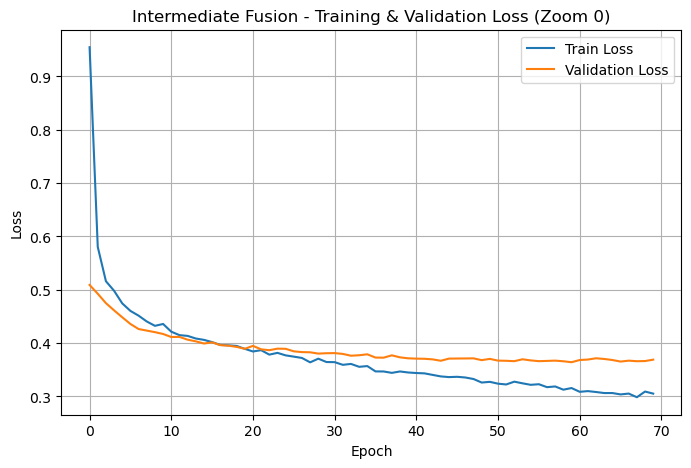

Intermediate Fusion - Zoom 0 - RMSE: 0.6019, R2: 0.3016

Training Late Fusion for zoom level 0
Epoch 1: Train Loss = 1.5006, Val Loss = 0.5385
Epoch 2: Train Loss = 0.8478, Val Loss = 0.4823
Epoch 3: Train Loss = 0.6722, Val Loss = 0.4635
Epoch 4: Train Loss = 0.5758, Val Loss = 0.4462
Epoch 5: Train Loss = 0.5279, Val Loss = 0.4414
Epoch 6: Train Loss = 0.4903, Val Loss = 0.4335
Epoch 7: Train Loss = 0.4684, Val Loss = 0.4290
Epoch 8: Train Loss = 0.4547, Val Loss = 0.4244
Epoch 9: Train Loss = 0.4374, Val Loss = 0.4234
Epoch 10: Train Loss = 0.4297, Val Loss = 0.4180
Epoch 11: Train Loss = 0.4241, Val Loss = 0.4151
Epoch 12: Train Loss = 0.4156, Val Loss = 0.4149
Epoch 13: Train Loss = 0.4120, Val Loss = 0.4157
Epoch 14: Train Loss = 0.4066, Val Loss = 0.4118
Epoch 15: Train Loss = 0.4002, Val Loss = 0.4113
Epoch 16: Train Loss = 0.3972, Val Loss = 0.4123
Epoch 17: Train Loss = 0.3986, Val Loss = 0.4090
Epoch 18: Train Loss = 0.3938, Val Loss = 0.4102
Epoch 19: Train Loss = 0.3901, V

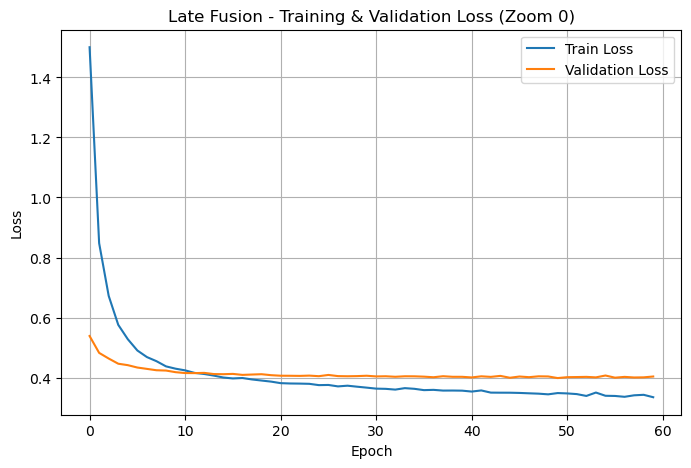

Late Fusion - Zoom 0 - RMSE: 0.6243, R2: 0.2485

Processing zoom level 1

Training Early Fusion for zoom level 1
Epoch 1: Train Loss = 0.6403, Val Loss = 0.4818
Epoch 2: Train Loss = 0.5022, Val Loss = 0.4628
Epoch 3: Train Loss = 0.4724, Val Loss = 0.4422
Epoch 4: Train Loss = 0.4585, Val Loss = 0.4365
Epoch 5: Train Loss = 0.4389, Val Loss = 0.4263
Epoch 6: Train Loss = 0.4222, Val Loss = 0.4185
Epoch 7: Train Loss = 0.4178, Val Loss = 0.4087
Epoch 8: Train Loss = 0.4092, Val Loss = 0.4074
Epoch 9: Train Loss = 0.3979, Val Loss = 0.4059
Epoch 10: Train Loss = 0.3970, Val Loss = 0.4033
Epoch 11: Train Loss = 0.3949, Val Loss = 0.3964
Epoch 12: Train Loss = 0.3855, Val Loss = 0.3916
Epoch 13: Train Loss = 0.3788, Val Loss = 0.3920
Epoch 14: Train Loss = 0.3789, Val Loss = 0.3877
Epoch 15: Train Loss = 0.3716, Val Loss = 0.3979
Epoch 16: Train Loss = 0.3680, Val Loss = 0.3864
Epoch 17: Train Loss = 0.3573, Val Loss = 0.3906
Epoch 18: Train Loss = 0.3599, Val Loss = 0.3801
Epoch 19: Trai

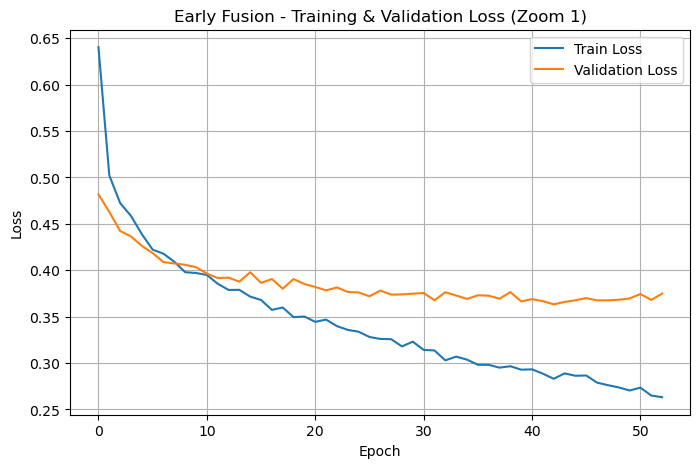

Early Fusion - Zoom 1 - RMSE: 0.6101, R2: 0.2823

Training Intermediate Fusion for zoom level 1
Epoch 1: Train Loss = 0.6718, Val Loss = 0.4927
Epoch 2: Train Loss = 0.5179, Val Loss = 0.4691
Epoch 3: Train Loss = 0.4864, Val Loss = 0.4537
Epoch 4: Train Loss = 0.4650, Val Loss = 0.4444
Epoch 5: Train Loss = 0.4533, Val Loss = 0.4366
Epoch 6: Train Loss = 0.4384, Val Loss = 0.4270
Epoch 7: Train Loss = 0.4327, Val Loss = 0.4219
Epoch 8: Train Loss = 0.4247, Val Loss = 0.4153
Epoch 9: Train Loss = 0.4277, Val Loss = 0.4121
Epoch 10: Train Loss = 0.4179, Val Loss = 0.4145
Epoch 11: Train Loss = 0.4139, Val Loss = 0.4098
Epoch 12: Train Loss = 0.4060, Val Loss = 0.4042
Epoch 13: Train Loss = 0.4038, Val Loss = 0.3999
Epoch 14: Train Loss = 0.3985, Val Loss = 0.3986
Epoch 15: Train Loss = 0.3951, Val Loss = 0.3965
Epoch 16: Train Loss = 0.3894, Val Loss = 0.3944
Epoch 17: Train Loss = 0.3874, Val Loss = 0.3903
Epoch 18: Train Loss = 0.3800, Val Loss = 0.3943
Epoch 19: Train Loss = 0.3845, 

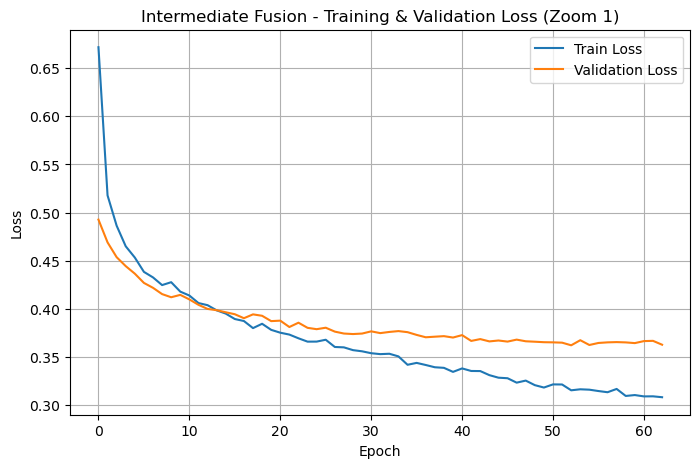

Intermediate Fusion - Zoom 1 - RMSE: 0.5981, R2: 0.3102

Training Late Fusion for zoom level 1
Epoch 1: Train Loss = 1.1923, Val Loss = 0.5260
Epoch 2: Train Loss = 0.7614, Val Loss = 0.4641
Epoch 3: Train Loss = 0.6366, Val Loss = 0.4463
Epoch 4: Train Loss = 0.5559, Val Loss = 0.4361
Epoch 5: Train Loss = 0.5047, Val Loss = 0.4317
Epoch 6: Train Loss = 0.4724, Val Loss = 0.4268
Epoch 7: Train Loss = 0.4586, Val Loss = 0.4234
Epoch 8: Train Loss = 0.4472, Val Loss = 0.4205
Epoch 9: Train Loss = 0.4335, Val Loss = 0.4181
Epoch 10: Train Loss = 0.4226, Val Loss = 0.4149
Epoch 11: Train Loss = 0.4082, Val Loss = 0.4127
Epoch 12: Train Loss = 0.4129, Val Loss = 0.4110
Epoch 13: Train Loss = 0.4071, Val Loss = 0.4121
Epoch 14: Train Loss = 0.4077, Val Loss = 0.4092
Epoch 15: Train Loss = 0.3982, Val Loss = 0.4088
Epoch 16: Train Loss = 0.3975, Val Loss = 0.4074
Epoch 17: Train Loss = 0.3911, Val Loss = 0.4060
Epoch 18: Train Loss = 0.3927, Val Loss = 0.4068
Epoch 19: Train Loss = 0.3867, V

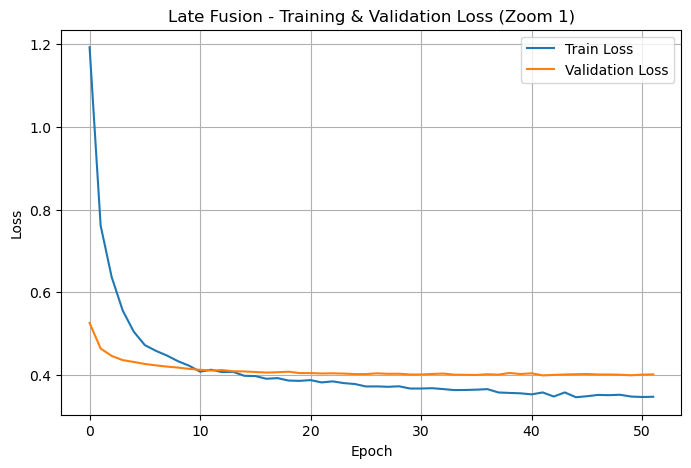

Late Fusion - Zoom 1 - RMSE: 0.6198, R2: 0.2594

Processing zoom level 2

Training Early Fusion for zoom level 2
Epoch 1: Train Loss = 0.7740, Val Loss = 0.4806
Epoch 2: Train Loss = 0.5309, Val Loss = 0.4609
Epoch 3: Train Loss = 0.4804, Val Loss = 0.4435
Epoch 4: Train Loss = 0.4654, Val Loss = 0.4309
Epoch 5: Train Loss = 0.4466, Val Loss = 0.4243
Epoch 6: Train Loss = 0.4283, Val Loss = 0.4236
Epoch 7: Train Loss = 0.4261, Val Loss = 0.4172
Epoch 8: Train Loss = 0.4146, Val Loss = 0.4211
Epoch 9: Train Loss = 0.4061, Val Loss = 0.4092
Epoch 10: Train Loss = 0.4032, Val Loss = 0.4050
Epoch 11: Train Loss = 0.4012, Val Loss = 0.4028
Epoch 12: Train Loss = 0.3925, Val Loss = 0.4124
Epoch 13: Train Loss = 0.3860, Val Loss = 0.3996
Epoch 14: Train Loss = 0.3859, Val Loss = 0.3985
Epoch 15: Train Loss = 0.3844, Val Loss = 0.3938
Epoch 16: Train Loss = 0.3717, Val Loss = 0.3938
Epoch 17: Train Loss = 0.3642, Val Loss = 0.3910
Epoch 18: Train Loss = 0.3652, Val Loss = 0.3903
Epoch 19: Trai

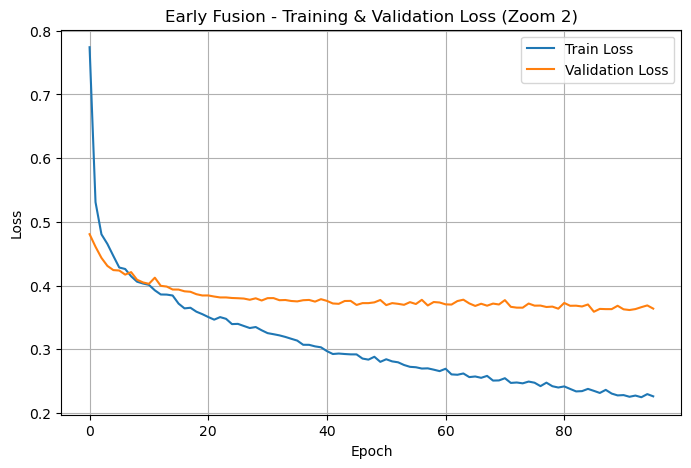

Early Fusion - Zoom 2 - RMSE: 0.5999, R2: 0.3061

Training Intermediate Fusion for zoom level 2
Epoch 1: Train Loss = 0.7119, Val Loss = 0.4909
Epoch 2: Train Loss = 0.5266, Val Loss = 0.4687
Epoch 3: Train Loss = 0.4940, Val Loss = 0.4487
Epoch 4: Train Loss = 0.4661, Val Loss = 0.4340
Epoch 5: Train Loss = 0.4500, Val Loss = 0.4258
Epoch 6: Train Loss = 0.4451, Val Loss = 0.4210
Epoch 7: Train Loss = 0.4293, Val Loss = 0.4157
Epoch 8: Train Loss = 0.4292, Val Loss = 0.4123
Epoch 9: Train Loss = 0.4120, Val Loss = 0.4043
Epoch 10: Train Loss = 0.4155, Val Loss = 0.4012
Epoch 11: Train Loss = 0.4152, Val Loss = 0.3977
Epoch 12: Train Loss = 0.4080, Val Loss = 0.3951
Epoch 13: Train Loss = 0.4085, Val Loss = 0.3957
Epoch 14: Train Loss = 0.4014, Val Loss = 0.3954
Epoch 15: Train Loss = 0.3989, Val Loss = 0.3906
Epoch 16: Train Loss = 0.3946, Val Loss = 0.3884
Epoch 17: Train Loss = 0.3886, Val Loss = 0.3944
Epoch 18: Train Loss = 0.3813, Val Loss = 0.3836
Epoch 19: Train Loss = 0.3791, 

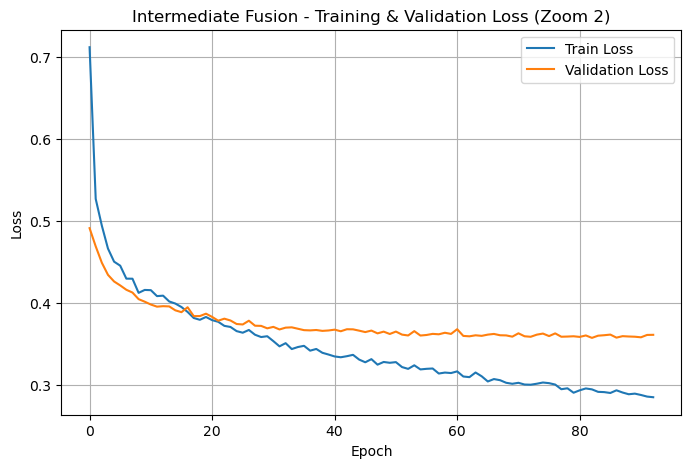

Intermediate Fusion - Zoom 2 - RMSE: 0.6003, R2: 0.3052

Training Late Fusion for zoom level 2
Epoch 1: Train Loss = 1.0198, Val Loss = 0.5044
Epoch 2: Train Loss = 0.7110, Val Loss = 0.4700
Epoch 3: Train Loss = 0.5893, Val Loss = 0.4492
Epoch 4: Train Loss = 0.5359, Val Loss = 0.4380
Epoch 5: Train Loss = 0.4927, Val Loss = 0.4350
Epoch 6: Train Loss = 0.4659, Val Loss = 0.4301
Epoch 7: Train Loss = 0.4460, Val Loss = 0.4229
Epoch 8: Train Loss = 0.4314, Val Loss = 0.4203
Epoch 9: Train Loss = 0.4225, Val Loss = 0.4185
Epoch 10: Train Loss = 0.4153, Val Loss = 0.4168
Epoch 11: Train Loss = 0.4145, Val Loss = 0.4139
Epoch 12: Train Loss = 0.4069, Val Loss = 0.4123
Epoch 13: Train Loss = 0.4062, Val Loss = 0.4118
Epoch 14: Train Loss = 0.4052, Val Loss = 0.4123
Epoch 15: Train Loss = 0.3960, Val Loss = 0.4090
Epoch 16: Train Loss = 0.3937, Val Loss = 0.4087
Epoch 17: Train Loss = 0.3981, Val Loss = 0.4076
Epoch 18: Train Loss = 0.3850, Val Loss = 0.4084
Epoch 19: Train Loss = 0.3900, V

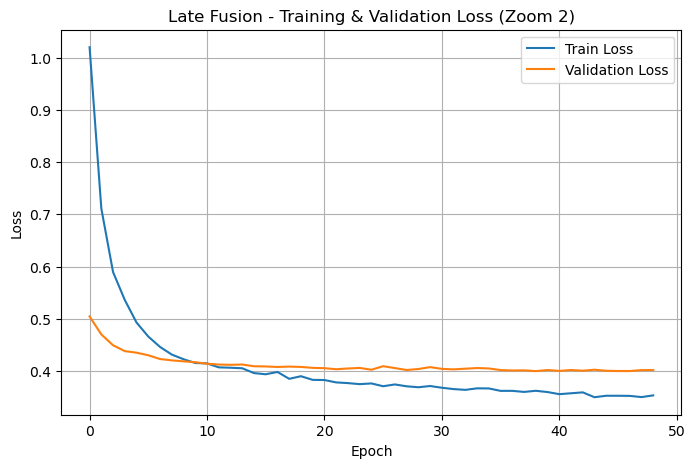

Late Fusion - Zoom 2 - RMSE: 0.6197, R2: 0.2596

Processing zoom level 3

Training Early Fusion for zoom level 3
Epoch 1: Train Loss = 0.6726, Val Loss = 0.4992
Epoch 2: Train Loss = 0.5072, Val Loss = 0.4636
Epoch 3: Train Loss = 0.4740, Val Loss = 0.4512
Epoch 4: Train Loss = 0.4445, Val Loss = 0.4271
Epoch 5: Train Loss = 0.4345, Val Loss = 0.4233
Epoch 6: Train Loss = 0.4253, Val Loss = 0.4091
Epoch 7: Train Loss = 0.4196, Val Loss = 0.4034
Epoch 8: Train Loss = 0.4076, Val Loss = 0.4046
Epoch 9: Train Loss = 0.4005, Val Loss = 0.3970
Epoch 10: Train Loss = 0.3930, Val Loss = 0.3944
Epoch 11: Train Loss = 0.3923, Val Loss = 0.3938
Epoch 12: Train Loss = 0.3812, Val Loss = 0.3956
Epoch 13: Train Loss = 0.3772, Val Loss = 0.3906
Epoch 14: Train Loss = 0.3790, Val Loss = 0.3894
Epoch 15: Train Loss = 0.3753, Val Loss = 0.3846
Epoch 16: Train Loss = 0.3668, Val Loss = 0.3833
Epoch 17: Train Loss = 0.3653, Val Loss = 0.3859
Epoch 18: Train Loss = 0.3628, Val Loss = 0.3791
Epoch 19: Trai

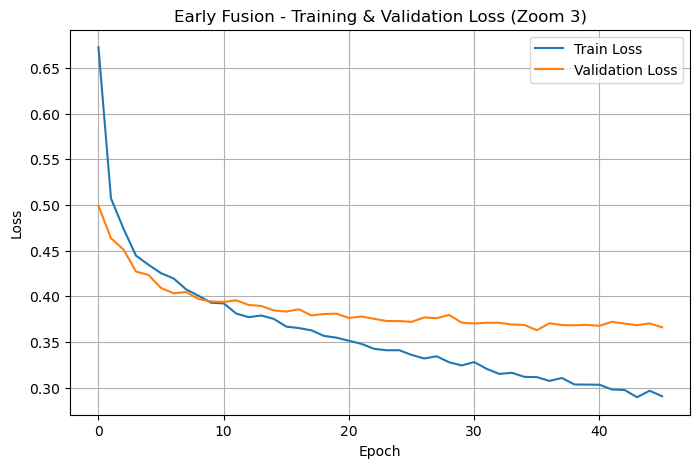

Early Fusion - Zoom 3 - RMSE: 0.6004, R2: 0.3050

Training Intermediate Fusion for zoom level 3
Epoch 1: Train Loss = 0.6475, Val Loss = 0.4913
Epoch 2: Train Loss = 0.5148, Val Loss = 0.4699
Epoch 3: Train Loss = 0.4809, Val Loss = 0.4509
Epoch 4: Train Loss = 0.4562, Val Loss = 0.4383
Epoch 5: Train Loss = 0.4534, Val Loss = 0.4307
Epoch 6: Train Loss = 0.4437, Val Loss = 0.4293
Epoch 7: Train Loss = 0.4350, Val Loss = 0.4207
Epoch 8: Train Loss = 0.4266, Val Loss = 0.4248
Epoch 9: Train Loss = 0.4198, Val Loss = 0.4148
Epoch 10: Train Loss = 0.4136, Val Loss = 0.4098
Epoch 11: Train Loss = 0.4100, Val Loss = 0.4043
Epoch 12: Train Loss = 0.4050, Val Loss = 0.4016
Epoch 13: Train Loss = 0.4018, Val Loss = 0.4017
Epoch 14: Train Loss = 0.3964, Val Loss = 0.3966
Epoch 15: Train Loss = 0.3941, Val Loss = 0.3992
Epoch 16: Train Loss = 0.3913, Val Loss = 0.3921
Epoch 17: Train Loss = 0.3860, Val Loss = 0.3901
Epoch 18: Train Loss = 0.3817, Val Loss = 0.3893
Epoch 19: Train Loss = 0.3825, 

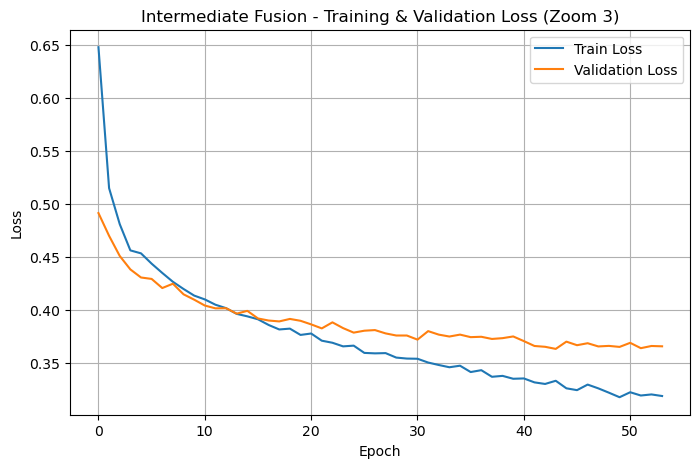

Intermediate Fusion - Zoom 3 - RMSE: 0.5961, R2: 0.3148

Training Late Fusion for zoom level 3
Epoch 1: Train Loss = 1.2591, Val Loss = 0.5470
Epoch 2: Train Loss = 0.7990, Val Loss = 0.4895
Epoch 3: Train Loss = 0.6760, Val Loss = 0.4648
Epoch 4: Train Loss = 0.5783, Val Loss = 0.4539
Epoch 5: Train Loss = 0.5468, Val Loss = 0.4381
Epoch 6: Train Loss = 0.5072, Val Loss = 0.4335
Epoch 7: Train Loss = 0.4706, Val Loss = 0.4272
Epoch 8: Train Loss = 0.4547, Val Loss = 0.4262
Epoch 9: Train Loss = 0.4502, Val Loss = 0.4202
Epoch 10: Train Loss = 0.4348, Val Loss = 0.4220
Epoch 11: Train Loss = 0.4278, Val Loss = 0.4159
Epoch 12: Train Loss = 0.4226, Val Loss = 0.4141
Epoch 13: Train Loss = 0.4157, Val Loss = 0.4156
Epoch 14: Train Loss = 0.4087, Val Loss = 0.4149
Epoch 15: Train Loss = 0.4077, Val Loss = 0.4110
Epoch 16: Train Loss = 0.3998, Val Loss = 0.4116
Epoch 17: Train Loss = 0.3986, Val Loss = 0.4103
Epoch 18: Train Loss = 0.3996, Val Loss = 0.4077
Epoch 19: Train Loss = 0.3959, V

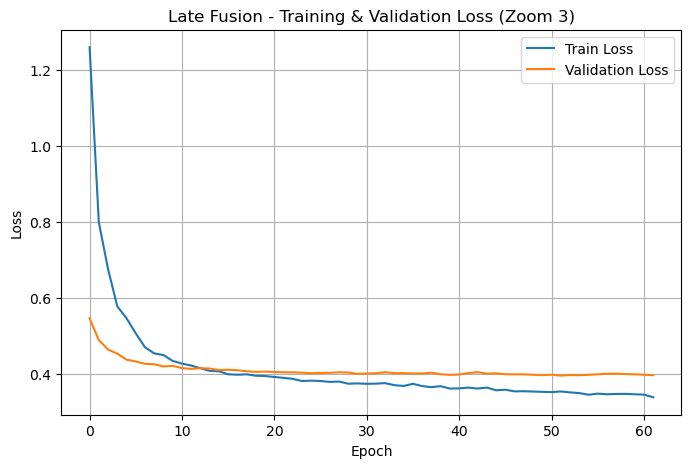

Late Fusion - Zoom 3 - RMSE: 0.6166, R2: 0.2669


In [16]:
# Loop over each zoom level
for zoom_level in range(4):
    print(f'\nProcessing zoom level {zoom_level}')
    
    # Data preparation: use fixed images from cropped_images[0] and spectra from the corresponding zoom level
    X_img_current = cropped_images[0].reshape(len(cropped_images[0]), -1)
    X_spec_current = all_spectra[zoom_level]
    
    # Split data into training, temporary (for validation/test), and then further split temporary into validation and test sets
    X_img_train, X_img_temp, X_spec_train, X_spec_temp, y_train, y_temp = train_test_split(
        X_img_current, X_spec_current, Y, test_size=0.4, random_state=42)

    X_img_val, X_img_test, X_spec_val, X_spec_test, y_val, y_test = train_test_split(
        X_img_temp, X_spec_temp, y_temp, test_size=0.5, random_state=42)

    # Missing value imputation
    imputer_spec = SimpleImputer(strategy="mean")
    imputer_img = SimpleImputer(strategy="mean")
    
    X_spec_train = imputer_spec.fit_transform(X_spec_train)
    X_spec_val = imputer_spec.transform(X_spec_val)
    X_spec_test = imputer_spec.transform(X_spec_test)

    X_img_train = imputer_img.fit_transform(X_img_train)
    X_img_val = imputer_img.transform(X_img_val)
    X_img_test = imputer_img.transform(X_img_test)

    # Feature scaling
    scaler_img = StandardScaler().fit(X_img_train)
    scaler_spec = StandardScaler().fit(X_spec_train)

    # PCA transformation
    pca_img = PCA(n_components=img_pca_components).fit(scaler_img.transform(X_img_train))
    pca_spec = PCA(n_components=spec_pca_components[zoom_level]).fit(scaler_spec.transform(X_spec_train))
    
    # Function for data transformation
    def transform_data(X_img, X_spec):
        return pca_img.transform(scaler_img.transform(X_img)), pca_spec.transform(scaler_spec.transform(X_spec))

    X_img_train_pca, X_spec_train_pca = transform_data(X_img_train, X_spec_train)
    X_img_val_pca, X_spec_val_pca = transform_data(X_img_val, X_spec_val)
    X_img_test_pca, X_spec_test_pca = transform_data(X_img_test, X_spec_test)

    # Create DataLoaders
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_img_train_pca, dtype=torch.float32), 
                      torch.tensor(X_spec_train_pca, dtype=torch.float32),
                      torch.tensor(y_train, dtype=torch.float32)),
        batch_size=batch_size, shuffle=True)
    
    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_img_val_pca, dtype=torch.float32), 
                      torch.tensor(X_spec_val_pca, dtype=torch.float32),
                      torch.tensor(y_val, dtype=torch.float32)),
        batch_size=batch_size)
    
    test_loader = DataLoader(
        TensorDataset(torch.tensor(X_img_test_pca, dtype=torch.float32), 
                      torch.tensor(X_spec_test_pca, dtype=torch.float32),
                      torch.tensor(y_test, dtype=torch.float32)),
        batch_size=batch_size)

    # Loop over each fusion method
    for fusion_name, fusion_class in fusion_methods.items():
        print(f"\nTraining {fusion_name} for zoom level {zoom_level}")

        if fusion_name == "Early Fusion":
            model = fusion_class(img_pca_components + spec_pca_components[zoom_level])
        elif fusion_name == "Intermediate Fusion":
            model = fusion_class(img_pca_components, spec_pca_components[zoom_level])
        else:  # Late Fusion
            model = fusion_class(img_pca_components, spec_pca_components[zoom_level])

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        best_val_loss, patience_counter = np.inf, 0
        best_model_weights = None
        
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(epochs):
            model.train()
            epoch_train_loss = 0  # accumulate batch losses
            for img, spec, y in train_loader:
                optimizer.zero_grad()
                if isinstance(model, EarlyFusionNet):
                    inputs = torch.cat([img, spec], dim=1)
                    pred = model(inputs).squeeze()
                else:
                    pred = model(img, spec).squeeze()
                
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
            avg_train_loss = epoch_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            epoch_val_loss = np.mean([
                criterion(
                    model(torch.cat([img, spec], dim=1)).squeeze() if isinstance(model, EarlyFusionNet) else model(img, spec).squeeze(),
                    y
                ).item()
                for img, spec, y in val_loader
            ])
            val_losses.append(epoch_val_loss)

            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")

            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                patience_counter = 0
                best_model_weights = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} for {fusion_name} - Zoom {zoom_level}")
                    break
        
        if best_model_weights is not None:
            model.load_state_dict(best_model_weights)
        
        # Plot training and validation loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{fusion_name} - Training & Validation Loss (Zoom {zoom_level})')
        plt.legend()
        plt.grid()
        plt.show()

        # Evaluate model on the test set
        model.eval()
        preds = []
        with torch.no_grad():
            for img, spec, _ in test_loader:
                if isinstance(model, EarlyFusionNet):
                    inputs = torch.cat([img, spec], dim=1)
                    pred = model(inputs).squeeze()
                else:
                    pred = model(img, spec).squeeze()
                preds.extend(pred.numpy())

        # Calculate RMSE instead of MSE
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        results_fusion[(zoom_level, fusion_name)] = {'RMSE': rmse, 'R2': r2}
        print(f"{fusion_name} - Zoom {zoom_level} - RMSE: {rmse:.4f}, R2: {r2:.4f}")

    Zoom Level        Fusion Method      RMSE        R2
0            0         Early Fusion  0.624691  0.247570
1            0  Intermediate Fusion  0.601860  0.301564
2            0          Late Fusion  0.624292  0.248531
3            1         Early Fusion  0.610087  0.282339
4            1  Intermediate Fusion  0.598107  0.310248
5            1          Late Fusion  0.619780  0.259354
6            2         Early Fusion  0.599917  0.306066
7            2  Intermediate Fusion  0.600312  0.305151
8            2          Late Fusion  0.619691  0.259567
9            3         Early Fusion  0.600378  0.304998
10           3  Intermediate Fusion  0.596146  0.314761
11           3          Late Fusion  0.616611  0.266908


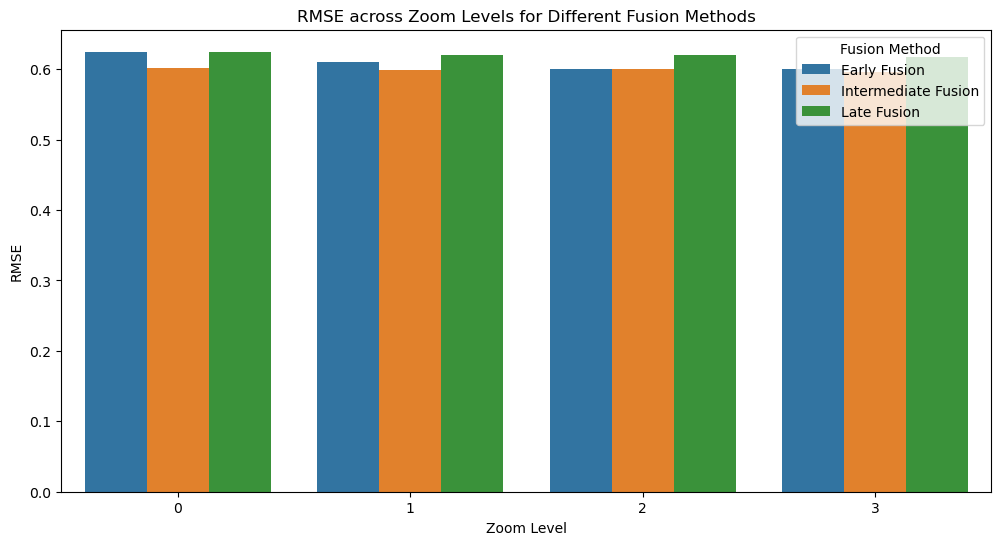

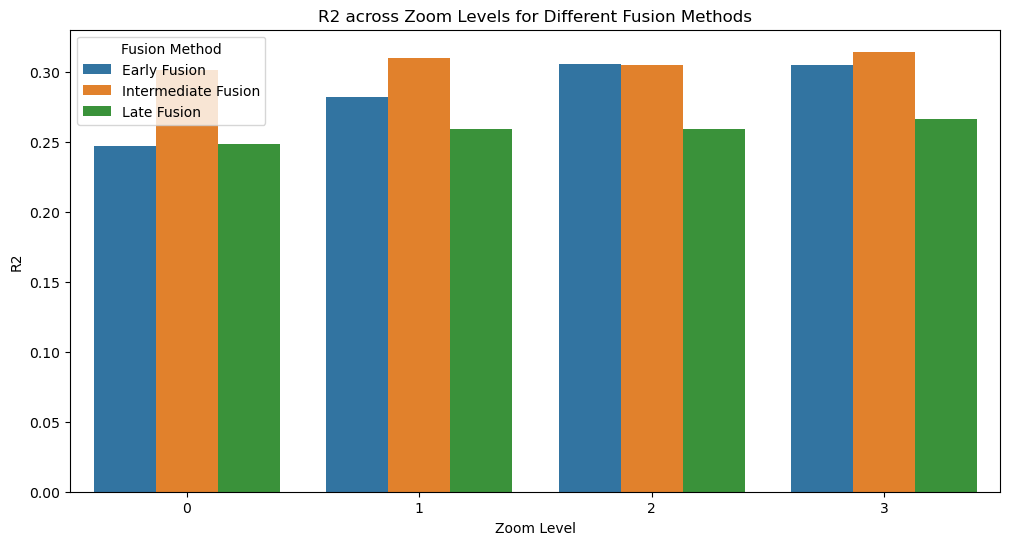

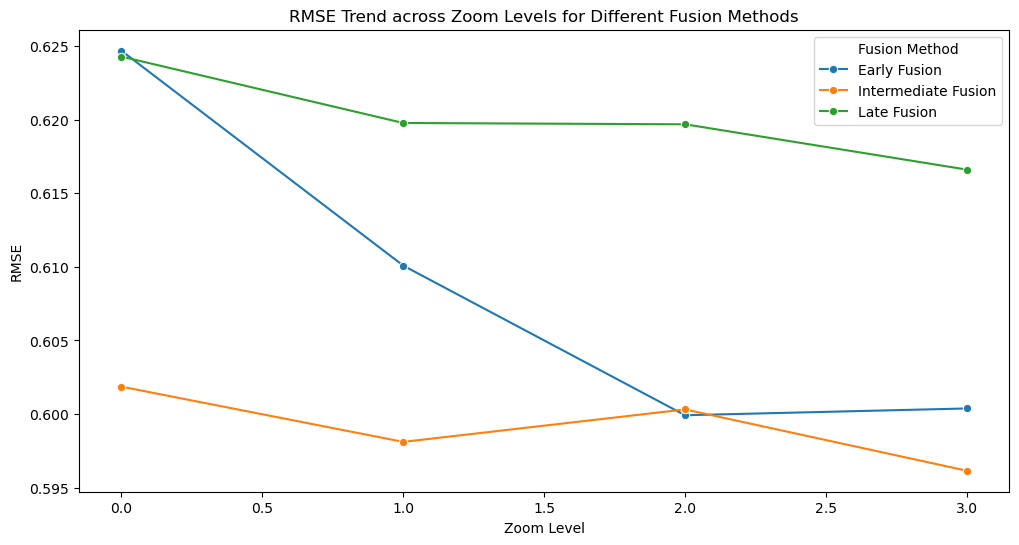

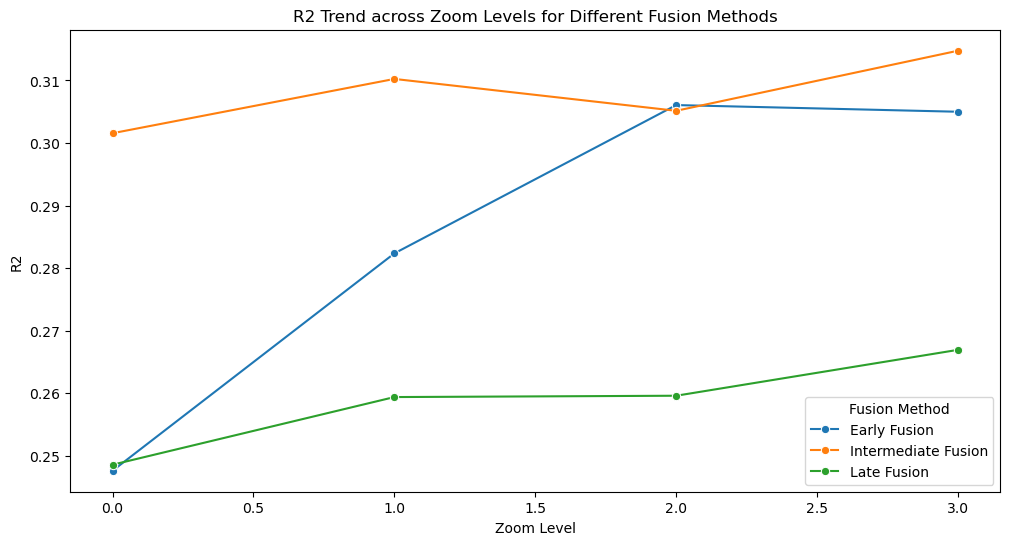

Top 3 configurations by RMSE:
    Zoom Level        Fusion Method      RMSE
10           3  Intermediate Fusion  0.596146
4            1  Intermediate Fusion  0.598107
6            2         Early Fusion  0.599917

Top 3 configurations by R2:
    Zoom Level        Fusion Method        R2
10           3  Intermediate Fusion  0.314761
4            1  Intermediate Fusion  0.310248
6            2         Early Fusion  0.306066


In [17]:
# -------------------------
# Visualization of results
import seaborn as sns

# Convert results to a DataFrame for visualization
results_df = pd.DataFrame([
    {"Zoom Level": zl, "Fusion Method": fm, "RMSE": res["RMSE"], "R2": res["R2"]}
    for (zl, fm), res in results_fusion.items()
])

print(results_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Zoom Level", y="RMSE", hue="Fusion Method")
plt.title("RMSE across Zoom Levels for Different Fusion Methods")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Zoom Level", y="R2", hue="Fusion Method")
plt.title("R2 across Zoom Levels for Different Fusion Methods")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Zoom Level", y="RMSE", hue="Fusion Method", marker="o")
plt.title("RMSE Trend across Zoom Levels for Different Fusion Methods")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Zoom Level", y="R2", hue="Fusion Method", marker="o")
plt.title("R2 Trend across Zoom Levels for Different Fusion Methods")
plt.show()

# Display the top 3 configurations based on RMSE and R2
top3_rmse = results_df.nsmallest(3, 'RMSE')[["Zoom Level", "Fusion Method", "RMSE"]]
top3_r2 = results_df.nlargest(3, 'R2')[["Zoom Level", "Fusion Method", "R2"]]

print("Top 3 configurations by RMSE:")
print(top3_rmse)
print("\nTop 3 configurations by R2:")
print(top3_r2)